In [1]:
import os
import time
import copy
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from utils_torch import *

In [2]:
!nvidia-smi

Tue Jan  4 19:15:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:37:00.0 Off |                    0 |
| N/A   49C    P0    38W / 250W |  25272MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   

In [3]:
'''Load training, validation and test data'''

batch_size = 32
input_shape = (192, 192, 3)
train_ids = pd.read_csv('csv_file/annot_training_set.csv')
val_ids = pd.read_csv('csv_file/annot_val_set.csv')
test_ids = pd.read_csv('csv_file/annot_test_set.csv')
print('training data:', len(train_ids))
print('valid data:',len(val_ids))
print('test data:',len(test_ids))

dataset_sizes = {'train':len(train_ids),'val':len(val_ids),'test':len(test_ids)}
print(dataset_sizes)


training data: 199603
valid data: 29245
test data: 54529
{'train': 199603, 'val': 29245, 'test': 54529}


In [4]:
'''Load labels for multi-class classification'''

names_to_labels = {}
df_class = pd.read_csv('36_class.csv',header=None)
for index, row in df_class.iterrows():
    names_to_labels[row[0]] = row[1]

print(len(names_to_labels))

36


In [5]:
df_1 = train_ids[train_ids['label'] == 'DHelmet']
df_2 = train_ids[train_ids['label'] == 'DNoHelmet']
df_3 = test_ids[test_ids['label'] == 'DHelmet']
df_4 = test_ids[test_ids['label'] == 'DNoHelmet']
df_5 = val_ids[val_ids['label'] == 'DHelmet']
df_6 = val_ids[val_ids['label'] == 'DNoHelmet']

df_dataset = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])
df_dataset = df_dataset.reset_index().iloc[:, 1:]

# data split|
train_ids = df_dataset.sample(frac=0.7, random_state=12345)
test_ids = df_dataset.drop(train_ids.index)
val_ids = test_ids.sample(frac=0.3333, random_state=12345)
test_ids = test_ids.drop(val_ids.index)

print('training data:', len(train_ids))
print('valid data:',len(val_ids))
print('test data:',len(test_ids))
dataset_sizes = {'train':len(train_ids),'val':len(val_ids),'test':len(test_ids)}
print(dataset_sizes)

training data: 114404
valid data: 16342
test data: 32689
{'train': 114404, 'val': 16342, 'test': 32689}


In [6]:
names_to_labels = {'DHelmet': 0, 'DNoHelmet': 1,}

In [7]:
train_set = HelmetDataset(ids=train_ids,
                          root_dir='/work1/fbohy/Helmet/images/',
                          names_to_labels = names_to_labels,
                          transform=transforms.Compose([
                              transforms.RandomRotation(10),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((192,192)),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]))


val_set = HelmetDataset(ids=val_ids,
                        root_dir='/work1/fbohy/Helmet/images/',
                        names_to_labels = names_to_labels,
                        transform=transforms.Compose([
                            transforms.Resize((192,192)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]))

test_set = HelmetDataset(ids=test_ids,
                         root_dir='/work1/fbohy/Helmet/images/',
                         names_to_labels = names_to_labels,
                         transform=transforms.Compose([
                             transforms.Resize((192,192)),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]))

dataloaders = {'train':DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)
               ,'val':DataLoader(val_set, batch_size=batch_size,shuffle=False, num_workers=4)
               ,'test':DataLoader(test_set, batch_size=batch_size,shuffle=False, num_workers=4)}
print(dataloaders)



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7faede770280>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7faede7702e0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7faede7705e0>}


In [8]:
def train_model(model, optimizer, scheduler, num_epochs=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    #best_loss = np.Inf
    best_acc = 0
    epoch_ACCs = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.   
            for i_batch, sample_batched in tqdm(enumerate(dataloaders[phase])):
                
                inputs, labels = sample_batched['image'], sample_batched['label']
                inputs, labels = inputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.LongTensor)
                inputs, labels = inputs.to(device), labels.to(device)
                
                
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(preds.shape,labels.shape)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                                   
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_ACCs.append(epoch_acc.item())

            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val loss: {:4f}'.format(best_loss))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_ACCs

In [9]:
torch.cuda.is_available()

True

In [10]:
'''Load pretrained model'''

model_ft = models.resnet34(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,len(names_to_labels))

#print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001)
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [16]:
savepath = 'save_model/best-cross-entropy'
if not os.path.isdir('save_model'):
    os.mkdir('save_model')
model_ft, epoch_ACCs = train_model(model_ft, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(model_ft.state_dict(), savepath)

Epoch 1/10
----------


3576it [17:29,  3.41it/s]

train Loss: 0.1212 Acc: 0.9551



511it [02:26,  3.50it/s]

val Loss: 0.0689 Acc: 0.9754

Epoch 2/10
----------



3576it [16:40,  3.58it/s]

train Loss: 0.0629 Acc: 0.9777



511it [02:21,  3.61it/s]

val Loss: 0.0465 Acc: 0.9830

Epoch 3/10
----------



3576it [16:41,  3.57it/s]

train Loss: 0.0467 Acc: 0.9833



511it [02:21,  3.62it/s]

val Loss: 0.0391 Acc: 0.9854

Epoch 4/10
----------



3576it [16:48,  3.55it/s]

train Loss: 0.0366 Acc: 0.9868



511it [02:23,  3.57it/s]

val Loss: 0.0416 Acc: 0.9864

Epoch 5/10
----------



3576it [16:46,  3.55it/s]

train Loss: 0.0299 Acc: 0.9888



511it [02:23,  3.56it/s]

val Loss: 0.0415 Acc: 0.9855

Epoch 6/10
----------



3576it [16:41,  3.57it/s]

train Loss: 0.0124 Acc: 0.9957



511it [02:21,  3.61it/s]

val Loss: 0.0224 Acc: 0.9928

Epoch 7/10
----------



3576it [16:46,  3.55it/s]

train Loss: 0.0067 Acc: 0.9976



511it [02:22,  3.59it/s]

val Loss: 0.0230 Acc: 0.9931

Epoch 8/10
----------



3576it [16:45,  3.56it/s]

train Loss: 0.0051 Acc: 0.9983



511it [02:22,  3.59it/s]

val Loss: 0.0237 Acc: 0.9932

Epoch 9/10
----------



3576it [16:43,  3.57it/s]

train Loss: 0.0039 Acc: 0.9988



511it [02:22,  3.57it/s]

val Loss: 0.0243 Acc: 0.9933

Epoch 10/10
----------



3576it [16:49,  3.54it/s]


train Loss: 0.0029 Acc: 0.9989


511it [02:23,  3.56it/s]


val Loss: 0.0259 Acc: 0.9925

Training complete in 192m 2s
Best val Acc: 0.993269


In [11]:
savepath = 'save_model/best-cross-entropy'
model_ft.load_state_dict(torch.load(savepath))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
!nvidia-smi

Tue Jan  4 19:16:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:37:00.0 Off |                    0 |
| N/A   49C    P0    38W / 250W |  25272MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   

In [14]:
'''Evaluation on test set'''
phase = 'test'
running_loss = 0.0
running_corrects = 0
y_pred = []
all_outputs = []
for i_batch, sample_batched in enumerate(dataloaders[phase]):
    inputs, labels = sample_batched['image'], sample_batched['label']
    inputs, labels = inputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.LongTensor)
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = model_ft(inputs)
    all_outputs.append(outputs.cpu().detach().numpy())
    _, preds = torch.max(outputs, 1)
    y_pred.append(preds.cpu().numpy())
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
    if i_batch % 50 == 49:
        print('[%5d] loss: %.3f' %(i_batch + 1, running_loss / (i_batch*20)))
                
    
epoch_loss = running_loss / dataset_sizes[phase]
epoch_acc = running_corrects.double() / dataset_sizes[phase]

print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

[   50] loss: 0.027
[  100] loss: 0.021
[  150] loss: 0.018
[  200] loss: 0.016
[  250] loss: 0.015
[  300] loss: 0.018
[  350] loss: 0.020
[  400] loss: 0.019
[  450] loss: 0.020
[  500] loss: 0.020
[  550] loss: 0.032
[  600] loss: 0.037
[  650] loss: 0.036
[  700] loss: 0.035
[  750] loss: 0.036
[  800] loss: 0.034
[  850] loss: 0.033
[  900] loss: 0.035
[  950] loss: 0.035
[ 1000] loss: 0.037
test Loss: 0.0233 Acc: 0.9941


In [20]:
all_outputs = np.concatenate(all_outputs)

In [58]:
outputs = torch.from_numpy(all_outputs)
sig_out = torch.sigmoid(outputs)
y_preds = torch.from_numpy(np.concatenate(y_pred))

In [114]:
def get_tpr_fpr(s):
    
    pos = torch.where(sig_out[:, 0] > s, 0, 1)
    tp = torch.sum(torch.logical_and(pos == 0, y_preds == 0))
    fp = torch.sum(torch.logical_and(pos == 0, y_preds == 1))
    tn = torch.sum(torch.logical_and(pos == 1, y_preds == 1))
    fn = torch.sum(torch.logical_and(pos == 1, y_preds == 0))
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

In [115]:
tprs =[]
fprs = []
for i in np.linspace(-0.1, 1.1, 1000):
    tpr, fpr = get_tpr_fpr(i)
    tprs.append(float(tpr))
    fprs.append(float(fpr))

In [126]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for line in open('learning_curve', 'r'):
    if line.startswith('train Loss'):
        line = line.split()
        train_loss.append(float(line[2]))
        train_acc.append(float(line[4]))
    elif line.startswith('val Loss'):
        line = line.split()
        val_loss.append(float(line[2]))
        val_acc.append(float(line[4]))

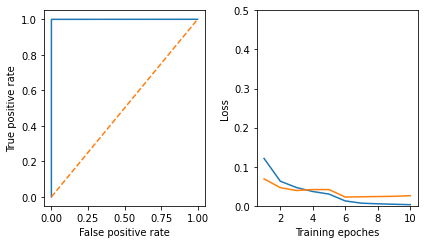

In [146]:
plt.subplot(121)
plt.plot(fprs, tprs)
plt.plot((0,1), (0,1), '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig('roc.jpg', dpi=300)

plt.subplot(122)
plt.plot(np.arange(10)+1, train_loss)
plt.plot(np.arange(10)+1, val_loss)
plt.ylim([0, 0.5])
plt.xlabel('Training epoches')
plt.ylabel('Loss')

fig = plt.gcf()
fig.set_size_inches(6,3.5)
fig.tight_layout()
plt.savefig('res_metrics.jpg', dpi = 300)

(0.0, 0.5)

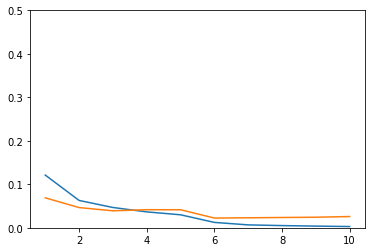

In [132]:
fig.set_size_inches()